# Monte Carlo Model of Radical Polymerization

## Introduction

As explained in [Notebook 2], stochastic methods can also be used — and are sometimes preferable — for simulating polymerization systems. To illustrate this approach, we reimplement the radical polymerization model from [Notebook 5] using the Kinetic Monte Carlo (KMC) method.

[Notebook 2]: ./2_kinetic_monte_carlo.ipynb
[Notebook 5]: ./5_radical_pbe_batch_polymerization.ipynb 

## Numerical Solution

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit
from numpy.typing import NDArray

### Stochastic Algorithm

The implementation closely follows the general principles outlined in [Notebook 2]. The main difference is that the reaction system now includes macromolecular species $R^{\cdot}_n$ and $P_n$, whose chain length distribution (CLD) we want to track. For that purpose, in addition to storing the total number of each of these species in the molecule count vector $X$, we compute and store their respective chain lengths in an additional (dynamic) list. That information is then used after the simulation is completed to reconstruct the full CLD.

For better readability, we define symbolic indices for the different species and reaction types used in the simulation. These indices will make the code more intuitive and reduce the likelihood of errors when referencing specific components.

In [2]:
IDX_M = 0   # Monomer
IDX_I = 1   # Initiator 
IDX_R = 2   # Radical
IDX_P = 3   # Polymer

IDX_RP  = 0 # Propagation
IDX_RD  = 1 # Initiator decomposition
IDX_RTC = 2 # Termination by combination
IDX_RTD = 3 # Termination by disproportion 

# Constants
NA = 6.022e23

The stochastic algorithm is implemented in `simulate_polymerization`, following the six steps outlined in [Notebook 2]. Due to the inherently low radical-to-monomer concentration ratio $[R^{\cdot}]/[M]$ in radical polymerizations, the simulation must consider a very large number ($>10^8$) of initial monomer molecules to accurately represent the radical population. This large number of molecules results in a proportionally high number of time steps. Therefore, an efficient implementation is essential, and the function is JIT-compiled with [Numba] to improve performance.  

[Numba]: https://numba.pydata.org/

In [3]:
@jit(fastmath=True)
def simulate_polymerization(C0: NDArray[np.float64],
                            kd: float,
                            f: float,
                            kp: float,
                            ktc: float,
                            ktd: float,
                            tend: float,
                            XM0: int,
                            number_snapshots: int = 100):

    # Initialize system state
    t = 0.
    X: NDArray[np.int64] = np.rint(XM0 / C0[IDX_M] * C0).astype(np.int64)
    V: float = X[IDX_M] / (C0[IDX_M]*NA)
    Rn: list[int] = [0]
    Pn: list[int] = [0]

    # Store initial state
    t_trajectory = [t]
    X_trajectory = [X.copy()]
    V_trajectory = [V]
    Rn_trajectory = [Rn.copy()]
    Pn_trajectory = [Pn.copy()]

    # Termination coefficients
    kt = ktc + ktd
    alpha = ktd/kt
    
    # Start loop
    a = np.zeros(4)
    while True:

        # Rescale rate coefficients
        kd_mc = kd
        kp_mc = kp/(NA*V)
        kt_mc = 2*(kt/2)/(NA*V)

        # Evaluate reaction propensities
        a[IDX_RD] = kd_mc*X[IDX_I]
        a[IDX_RP] = kp_mc*X[IDX_R]*X[IDX_M]
        at        = kt_mc*X[IDX_R]*(X[IDX_R] - 1)
        a[IDX_RTC] = at*(1 - alpha)
        a[IDX_RTD] = at*alpha

        # Select reaction
        a_cumsum = np.cumsum(a)
        a_sum = a_cumsum[-1]
        rand_rxn = np.random.rand()*a_sum
        idx_selected_rxn = np.searchsorted(a_cumsum, rand_rxn)

        # Update number of molecules, chain lengths and volume change
        if idx_selected_rxn == IDX_RD:
            X[IDX_I] -= 1
            ΔV = 0
            if np.random.rand() > f:
                X[IDX_M] -= 2
                X[IDX_R] += 2
                Rn.append(1)
                Rn.append(1)
                ΔV = 0
        elif idx_selected_rxn == IDX_RP:
            X[IDX_M] -= 1
            idx_Rn = np.random.randint(len(Rn))
            Rn[idx_Rn] += 1
            ΔV = 0
        elif idx_selected_rxn == IDX_RTC:
            X[IDX_R] -= 2
            X[IDX_P] += 1
            idx_Rn = np.random.randint(len(Rn))
            Pn_ = Rn[idx_Rn]
            Rn.pop(idx_Rn)
            idx_Rn = np.random.randint(len(Rn))
            Pn_ += Rn[idx_Rn]
            Rn.pop(idx_Rn)
            Pn.append(Pn_)
            ΔV = 0
        elif idx_selected_rxn == IDX_RTD:
            X[IDX_R] -= 2
            X[IDX_P] += 2
            for _ in range(2):
                idx_Rn = np.random.randint(len(Rn))
                Pn.append(Rn[idx_Rn])
                Rn.pop(idx_Rn)
            ΔV = 0
        else:
            raise ValueError("Invalid reaction index.")

        # Update volume
        V += ΔV

        # Elapsed time
        rand_tau = np.random.rand()
        if a_sum > 0:
            tau = (1/a_sum)*np.log(1/rand_tau)
        else:
            tau = tend - t
        t += tau

        #  Store state snapshot
        if (t/tend*number_snapshots - 1 > len(t_trajectory)):
            t_trajectory.append(t)
            X_trajectory.append(X.copy())
            V_trajectory.append(V)
            Rn_trajectory.append(Rn.copy())
            Pn_trajectory.append(Pn.copy())

        # Stop if end time reached
        if t >= tend or X[IDX_M] == 0 or X[IDX_I] == 0:
            break
        
    # Convert to numpy arrays
    t_ = np.asarray(t_trajectory)
    V_ = np.asarray(V_trajectory)
    X_ = np.empty((len(X_trajectory), X_trajectory[0].size), dtype=np.int64)
    for i in range(len(X_trajectory)):
        X_[i, :] = X_trajectory[i]
    Rn_ = [np.array(x) for x in Rn_trajectory]
    Pn_ = [np.array(x) for x in Pn_trajectory]

    # Compute molar species concentrations
    C_ = X_/(V_[:, np.newaxis]*NA)
             
    return t_, V_, X_, C_, Rn_, Pn_

### Input Parameters

For consistency, we use the same parameters as in [Notebook 5]. However, feel free to experiment with them!

In [4]:
f = 0.5
kd = 4e-4  # 1/s
kp = 4e3   # L/(mol.s)
ktc = 1e8  # L/(mol.s)
ktd = 1e8  # L/(mol.s)

C0 = np.array([1e0, 1e-2, 0., 0.])  # mol/L
tend = 3.6e3  # s

### Run Simulation

Now, let's roll the dice! 🎲

The initial number of monomer molecules is set to $10^8$ to keep the computation time within reasonable bounds. For more accurate results, consider increasing this number to around $10^9$. 

In [5]:
t, V, X, C, Rn, Pn = \
     simulate_polymerization(C0, kd, f, kp, ktc, ktd, tend, XM0=10**8)

On my computer, a simulation with `XM0=10**8` takes around 9 seconds. Since computation time scales linearly with the system size, a simulation with `XM0=10**9` takes about 1.5 minutes, which is still quite reasonable.

### Plots

#### Species Concentrations

Let's start by visualizing the time evolution of the molar concentrations of all species. For polymeric species, this corresponds to their zeroth moment.

Text(0.5, 23.52222222222222, 'Time [s]')

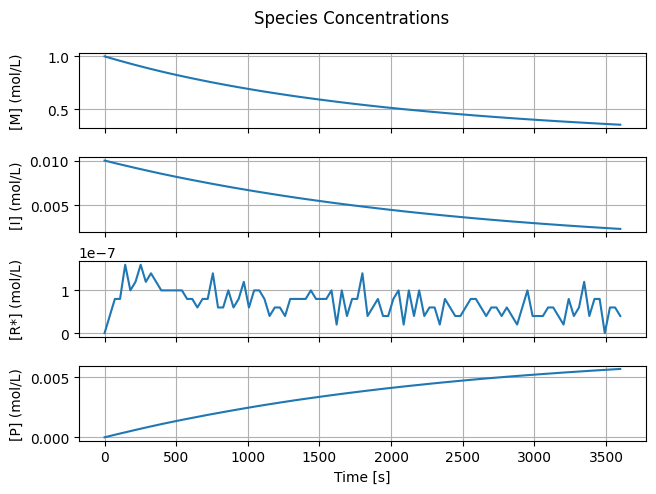

In [6]:
fig1, ax = plt.subplots(4, 1, sharex=True)
fig1.suptitle("Species Concentrations")
fig1.tight_layout()
fig1.align_ylabels()

for species, idx in zip(['I', 'M', 'R*', 'P'], [IDX_I, IDX_M, IDX_R, IDX_P]):
    ax[idx].plot(t, C[:, idx])
    ax[idx].set_ylabel(f"[{species}] (mol/L)")
    ax[idx].grid(True)

ax[-1].set_xlabel("Time [s]")

Note that the $[R^{\cdot}]$ curve is particularly noisy, while the other curves appear smooth. This noise is a direct consequence of the very low steady-state radical concentration (~$10^{-7}$ mol/L), which corresponds to just $10^1$ radicals in a simulation with $10^8$ monomer molecules.

### Average Chain Lengths

The leading moments of the radical and dead polymer distributions can be calculated from the lengths of the individual chains. From these, the number- and mass-average degrees of polymerization and the polydispersity index can be computed.

In [7]:
def moment(Q: list[np.ndarray], m: int) -> np.ndarray:
    "m-th moment of `Q`"
    if m == 0:
        result = [q.size for q in Q]
    elif m == 1:
        result = [q.sum() for q in Q]
    else:
        result = [np.sum(q**m) for q in Q]
    return np.array(result)

In [8]:
mu_R = [moment(Rn, m) for m in range(3)]
mu_P = [moment(Pn, m) for m in range(3)]

Text(0.5, 23.52222222222222, 'Time (s)')

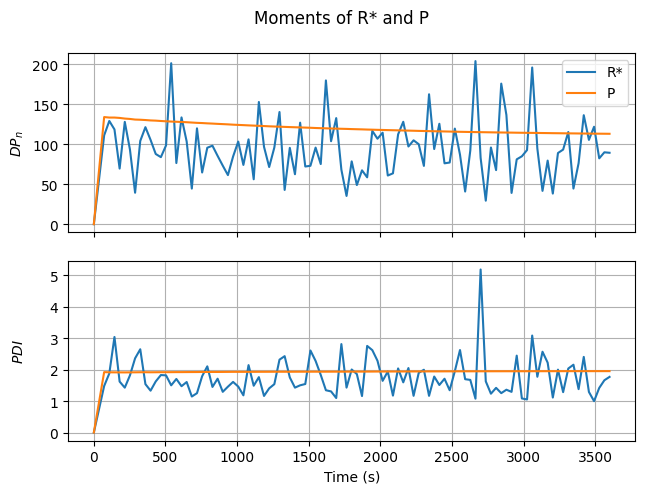

In [9]:
fig2, ax = plt.subplots(2, 1, sharex=True)
fig2.suptitle("Moments of R* and P")
fig2.tight_layout()
fig2.align_ylabels()

for mu, name in zip([mu_R, mu_P], ["R*", "P"]):
    DPn = mu[1]/(mu[0] + 1e-10)
    DPw = mu[2]/(mu[1] + 1e-10)
    PDI = DPw/(DPn + 1e-10)
    ax[0].plot(t, DPn, label=name)
    ax[1].plot(t, PDI, label=name)
    ax[0].set_ylabel(r"$DP_n$")
    ax[1].set_ylabel(r"$PDI$")
    ax[0].grid(True)
    ax[1].grid(True)

ax[0].legend(loc='upper right')
ax[-1].set_xlabel("Time (s)")

The values are plausible for both distributions, though significantly noisy for $R^{\cdot}$ due to the small radical sample. You may want to set `ktc` or `ktd` to zero and observe how this affects the average chain length and polydispersity index of the dead polymer.

### Chain Length Distribution

Last but not least, we can try to reconstruct the full chain length distributions of $R^{\cdot}$ and $P$.

Text(0.5, 23.52222222222222, 'Chain length')

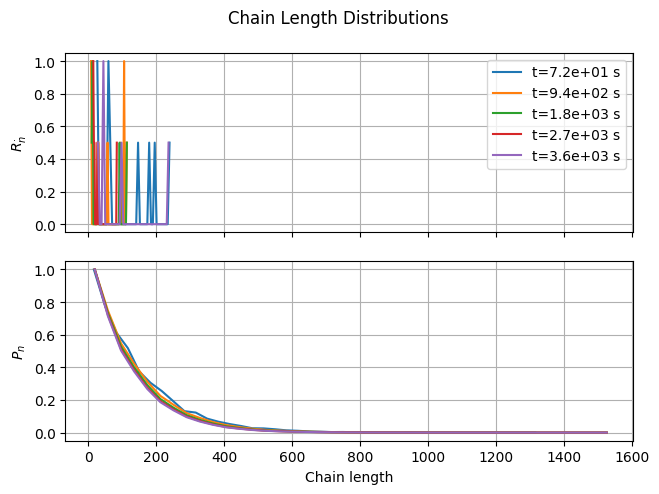

In [10]:
fig3, ax = plt.subplots(2, 1, sharex=True)
fig3.suptitle("Chain Length Distributions")
fig3.tight_layout()
fig3.align_ylabels()

for i, (Y, Yname) in enumerate(zip([Rn, Pn], [r"$R^{.}_n$", r"$P_n$"])):
    for ii in [1, int(0.25*len(t)), int(0.5*len(t)), int(0.75*len(t)), -1]:
        y, x = np.histogram(Y[ii], bins=40, density=False)
        x = (x[:-1] + x[1:])/2
        y = y/y.max()
        label = f"t={t[ii]:.1e} s"
        ax[i].plot(x, y, label=label)
    
    ax[i].set_ylabel(Yname)
    ax[i].grid(True)

ax[0].legend(loc='best')
ax[-1].set_xlabel("Chain length")

The dead polymer CLD exhibits the expected Flory-like shape, while the radical CLD is meaningless... To obtain a proper curve, a significantly larger radical count would be required.

## 🔎 Questions

1. Based on this example, how would you evaluate the performance of the KMC method for radical polymerization and, more generally, for reaction systems with low-concentration transient species?
1. The accuracy of the stochastic simulation can be improved not only by increasing `XM0`, but also by running multiple simulations with lower `XM0` and combining their results. Implement this approach.